In [1]:

# Imports
import torch
import typing
import pydantic
import bittensor as bt

# Stable diffusion
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline
from typing import List, Dict, Union, Tuple, Optional

import torchvision.transforms as transforms

bt.debug()

# Lets instantiate the stable diffusion model.
model =  StableDiffusionPipeline.from_pretrained( "prompthero/openjourney-v4", custom_pipeline="lpw_stable_diffusion", torch_dtype=torch.float16 ).to('cuda')

transform = transforms.Compose([
    transforms.PILToTensor()
])

class TextToImage( bt.Synapse ):
    image: typing.Optional[ bt.Tensor ] = None
    text: str = pydantic.Field( ..., allow_mutation = False)
    height: int = 512
    width: int = 512
    num_images_per_prompt: int = 1 
    num_inference_steps: int = 50
    guidance_scale: float = 7.5 
    negative_prompt: str = ""
    seed: int = -1

def text_to_image( synapse: TextToImage ) -> TextToImage:

    seed = synapse.seed

    if(seed == -1):
        seed = torch.randint(1000000000, (1,)).item()

    generator = torch.Generator(device='cuda').manual_seed(seed)

    output = model(
        prompt = synapse.text,
        height = synapse.height,
        width = synapse.width,
        num_images_per_prompt = synapse.num_images_per_prompt,
        num_inference_steps = synapse.num_inference_steps,
        guidance_scale = synapse.guidance_scale,
        negative_prompt = synapse.negative_prompt,
        generator = generator
    )

    image = output.images[0]
  
    # transform = transforms.PILToTensor()
    # Convert the PIL image to Torch tensor
    img_tensor = transform(image)

    synapse.image = bt.Tensor.serialize( img_tensor )
    
    return synapse



[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'
/home/creativebuilds/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [2]:
axon = bt.axon()

In [3]:
axon.attach( text_to_image ).start()

Axon([::], 8091, 5Ef1b7Xk6EtMPaewxw2WhdWMF5VtQDvBJwTKdTZF7ZbyBxdX, started, ['Synapse', 'TextToImage'])

In [4]:
d = bt.dendrite()

In [5]:
resp = await d(axon, TextToImage( text = "A beautiful landscape with a mountain in the background." ))

2023-07-15 12:24:31.974 |      DEBUG       | dendrite | --> | 4022 B | TextToImage | 5Ef1b7Xk6EtMPaewxw2WhdWMF5VtQDvBJwTKdTZF7ZbyBxdX | 66.67.59.249:8091 | 0 | Success
2023-07-15 12:24:31.994 |      DEBUG       | axon     | <-- | 4050 B | TextToImage | 5Ef1b7Xk6EtMPaewxw2WhdWMF5VtQDvBJwTKdTZF7ZbyBxdX | 127.0.0.1:48226 | 200 | Success 


  0%|          | 0/50 [00:00<?, ?it/s]

2023-07-15 12:24:36.057 |      DEBUG       | axon     | --> | 4050 B | TextToImage | 5Ef1b7Xk6EtMPaewxw2WhdWMF5VtQDvBJwTKdTZF7ZbyBxdX | 127.0.0.1:48226  | 200 | Success
2023-07-15 12:24:36.068 |      DEBUG       | dendrite | <-- | 1053911 B | TextToImage | 5Ef1b7Xk6EtMPaewxw2WhdWMF5VtQDvBJwTKdTZF7ZbyBxdX | 66.67.59.249:8091 | 200 | Success


In [6]:
tensor = resp.image.deserialize()

In [7]:
img = transforms.ToPILImage()(tensor)

In [8]:
import requests

from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

# load a fine-tuned image captioning model and corresponding tokenizer and image processor

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# let's perform inference on an image

image = img

pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)

generated_ids = model.generate(pixel_values)

generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.7.crossattention.bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.transformer.h.1.crossattention.masked_bias', 'decoder.transformer.h.11.crossattention.masked_bias', 'decoder.transformer.h.7.attn.bias', 'decoder.transformer.h.1.crossattention.bias', 'decoder.transformer.h.4.crossattention.bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.6.crossattention.masked_bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.8.crossattention.masked_bias', 'decoder.transformer.h.10.crossattention.bias', 'decoder.transformer.h.1.attn.masked_bias', 'decoder.transformer.h.3.attn.bias', 'decoder.transformer.h.7.crossattention.masked_bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transfo

a mountain range with a mountain range 


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, RobertaModel

import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model = RobertaModel.from_pretrained("roberta-base")



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
inputs = tokenizer(generated_text, return_tensors="pt")

outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state[-1][-1]

In [22]:
output_embedding = last_hidden_states

In [19]:
inputs = tokenizer(resp.text, return_tensors="pt")

outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

input_embedding = last_hidden_states[-1][-1]

In [18]:
last_hidden_states[-1][-1].shape

torch.Size([768])

In [26]:
cosine_similarity(input_embedding.reshape((1, -1)).detach().numpy(), output_embedding.reshape((1, -1)).detach().numpy()).item()

0.9327424764633179

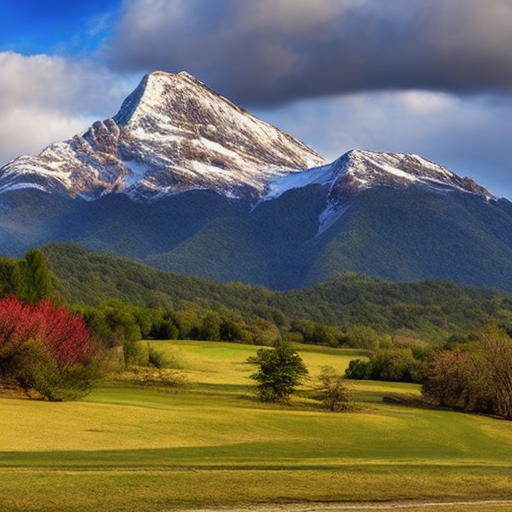

In [10]:
img

In [4]:
# Stable diffusion
import torch
import transformers
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline

# Lets instantiate the stable diffusion model.
model =  StableDiffusionPipeline.from_pretrained( "prompthero/openjourney-v4", custom_pipeline="lpw_stable_diffusion", torch_dtype=torch.float16 ).to('cuda')


/home/creativebuilds/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [6]:
image = model(prompt="A sunny day")

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
output = image

In [8]:
from PIL import Image
import torchvision.transforms as transforms

In [10]:
image = output.images[0]

In [11]:
transform = transforms.Compose([
    transforms.PILToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(image)

In [12]:
img_tensor.dtype

torch.uint8